### Importing the Dataset

In [1]:
import numpy as np
import pandas as pd
import keras
import json


fp = open("../data/total_posts.json")
posts_data = json.load(fp)
posts = pd.DataFrame.from_csv(posts_data)

2024-06-23 12:16:09.513941: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 12:16:09.546087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 12:16:10.095526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AttributeError: type object 'DataFrame' has no attribute 'from_csv'

### Exploring the Dataset

In [2]:
posts

,text,label
0,Today I fucked up at work. I’m not sure if I w...,1
1,The amount of child hate and parent shaming on...,1
2,I don’t know how to convince myself that even...,1
3,Do we know if any of the old SPSF Kodachrome p...,0
4,I told the sunset about you\n\nI told the suns...,1
...,...,...
1836,I’m never sure how to answer the question abou...,1
1837,Just people who have people. They can choose f...,1
1838,"If you could only drink non alcoholic beer, wo...",1
1839,"Hello, I’ve been struggling on and off with br...",1


In [3]:
posts.describe()

,label
count,1841.000000
mean,0.735470
std,0.441203
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


### Splitting the Dataset

In [4]:
from sklearn.model_selection import train_test_split


strat_train_set, strat_test_set = train_test_split(posts, test_size=0.2, random_state=42)

#### Analyzing the Dataset

In [5]:
posts = strat_train_set.copy()
posts.head()

,text,label
588,Got Covid for the 2nd time in early October. T...,1
949,2/3/2023\n\nTokophobia\n\nI stare at those lin...,0
1631,I am not implying that I got 100% okay from ju...,1
1719,Omgggggggggggggggg. New song new song new song...,1
1338,My family doesn’t do shit I’m the only boy &am...,1


In [14]:
post_lengths = [len(post.split()) for post in posts["text"]]

In [15]:
post_lengths[:10]

[31, 467, 610, 30, 134, 237, 36, 188, 512, 154]

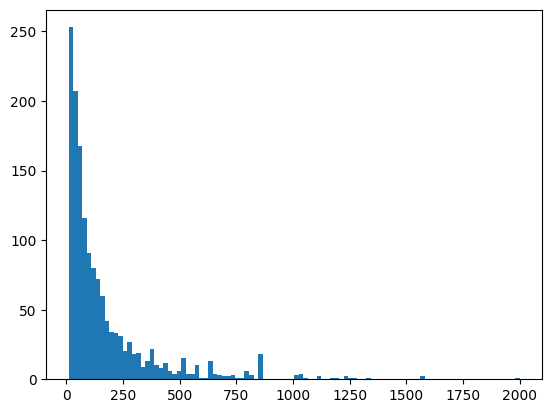

In [20]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Building the Classifier

#### Spliting the dataset (again)

In [78]:
strat_train_set, strat_val_set = train_test_split(posts, test_size=0.25, random_state=1)

print(strat_train_set)

texts = strat_train_set.copy()['text']
labels = strat_train_set.copy()['label']
val_texts = strat_val_set.copy()['text']
val_labels = strat_val_set.copy()['label']

                                                   text  label
1683  I feel like crying because I feel like I lost ...      1
1060  The qEEG results identify abnormalities in the...      1
815   You were talking about my struggles (that mean...      1
1390  It doesn't get gradually warm. You be wearing ...      1
1004  What does everyone use to mark packages?- eith...      0
...                                                 ...    ...
905   Yesterday morning my gf(21) broke up with me(2...      1
1791  So like most human beings I masturbate, and do...      1
1096  I lost my bestfriend to suicide this morning. ...      1
235   today mum told me i should have never been bor...      1
1061  hi! is there anyone who has a spare ticket or ...      1

[1380 rows x 2 columns]


In [79]:
texts, labels

(1683    I feel like crying because I feel like I lost ...
 1060    The qEEG results identify abnormalities in the...
 815     You were talking about my struggles (that mean...
 1390    It doesn't get gradually warm. You be wearing ...
 1004    What does everyone use to mark packages?- eith...
                               ...                        
 905     Yesterday morning my gf(21) broke up with me(2...
 1791    So like most human beings I masturbate, and do...
 1096    I lost my bestfriend to suicide this morning. ...
 235     today mum told me i should have never been bor...
 1061    hi! is there anyone who has a spare ticket or ...
 Name: text, Length: 1380, dtype: object,
 1683    1
 1060    1
 815     1
 1390    1
 1004    0
        ..
 905     1
 1791    1
 1096    1
 235     1
 1061    1
 Name: label, Length: 1380, dtype: int64)

#### Tokenizing the posts

In [80]:
from keras_preprocessing.text import Tokenizer       # type: ignore

tokenizer = Tokenizer(num_words=1000, oov_token='<UNK>')
tokenizer.fit_on_texts(texts)

In [81]:
from keras_preprocessing.sequence import pad_sequences

max_len=200

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

padded_train_seq = get_sequences(tokenizer, texts)
train_labels = np.array(labels)

#### Creating the model

In [82]:
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(1000, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(  
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [83]:
padded_train_seq

array([[  2,  33,  24, ...,   1,   1,   2],
       [  5,   1,   1, ...,   0,   0,   0],
       [ 21, 149, 340, ...,   0,   0,   0],
       ...,
       [  2, 255,   7, ...,   0,   0,   0],
       [254,   1, 160, ...,   0,   0,   0],
       [692,  13,  76, ...,   0,   0,   0]], dtype=int32)

In [85]:
from sklearn.utils.class_weight import compute_class_weight

val_seq = get_sequences(tokenizer, val_texts)
val_labels = np.array(val_labels)


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

{0: 1.880108991825613, 1: 0.6811451135241856}
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8266 - loss: 0.4143 - val_accuracy: 0.6855 - val_loss: 0.5999
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8611 - loss: 0.3283 - val_accuracy: 0.7028 - val_loss: 0.6501
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8763 - loss: 0.2812 - val_accuracy: 0.7549 - val_loss: 0.5462
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.8069 - loss: 0.3384 - val_accuracy: 0.7354 - val_loss: 0.5100
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8332 - loss: 0.4013 - val_accuracy: 0.7527 - val_loss: 0.5324


### Evaluating the Model

In [86]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 200, 40)        │         5,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 40)             │         9,760 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,288 (372.22 KB)

 Trainable params: 31,762 (124.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,526 (248.15 KB)

In [94]:
test_texts = strat_test_set.copy()['text']
test_labels = strat_test_set.copy()['label']

test_seq = get_sequences(tokenizer, test_texts)
test_labels = np.array(test_labels)

In [95]:
test_seq, test_labels

(array([[666,   6, 351, ...,   0,   0,   0],
        [  1,   1,  13, ...,   0,   0,   0],
        [147, 536,  78, ...,   0,   0,   0],
        ...,
        [243,  14,   1, ...,   0,   0,   0],
        [  2,   1,  23, ...,   0,   0,   0],
        [223, 146,   3, ...,   0,   0,   0]], dtype=int32),
 array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1

In [96]:
_ = model.evaluate(test_seq, test_labels)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8448 - loss: 0.3571


In [97]:
y_pred = model.predict(test_seq)
y_pred = (y_pred > 0.5).astype(int)

y_pred = np.array(list(map(lambda x: x[1], y_pred)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [99]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

False Positive Rate: 0.1944
False Negative Rate: 0.1264


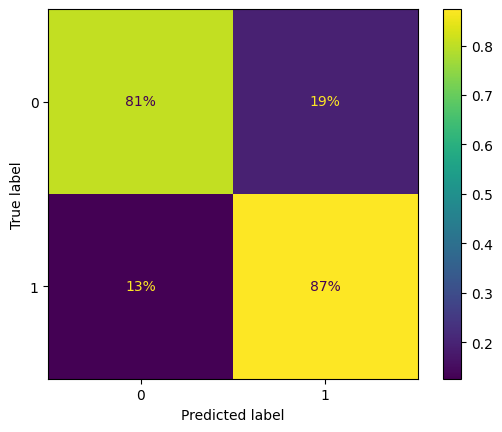

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()